<a href="https://colab.research.google.com/github/rifqoi/Inacure-Machine-Learning/blob/main/05-final_fix_uye.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset from Google Drive

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')
# !unzip  drive/Shareddrives/Bangkit\ Capstone/leaf_datasets.zip -d .

Mounted at /content/drive


# Import Libraries

In [ ]:
import re
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

import cv2
from google.colab.patches import cv2_imshow


tf.keras.utils.set_random_seed(42)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from shutil import copyfile

# List directories for each datasets

In [ ]:
dataset_dir = f"/content/drive/Shareddrives/Bangkit Capstone/Final_Split_Datasets"
train_dir = os.path.join(dataset_dir, "train")
validation_dir = os.path.join(dataset_dir, "validation")
test_dir = os.path.join(dataset_dir, "test")

# List Images

In [ ]:
def list_images():
  classes_dirs = os.listdir(train_dir)
  for folder in classes_dirs:
    train_classes = os.listdir(os.path.join(train_dir, folder))
    validation_classes = os.listdir(os.path.join(validation_dir, folder))
    test_classes = os.listdir(os.path.join(test_dir, folder))
    print(f"{folder}: \n \t{len(train_classes)} train images, {len(validation_classes)} validation images, and {len(test_classes)} test images,  total {len(train_classes) + len(validation_classes) + len(test_classes)} images")
    print()
list_images()

Lemon: 
 	151 train images, 42 validation images, and 23 test images,  total 216 images

Mangga: 
 	304 train images, 86 validation images, and 45 test images,  total 435 images

Jambu Biji: 
 	338 train images, 96 validation images, and 50 test images,  total 484 images

Jamblang: 
 	226 train images, 64 validation images, and 34 test images,  total 324 images

Delima: 
 	251 train images, 71 validation images, and 37 test images,  total 359 images

Anggur: 
 	245 train images, 69 validation images, and 37 test images,  total 351 images

Kedelai: 
 	245 train images, 69 validation images, and 37 test images,  total 351 images

Apel: 
 	245 train images, 69 validation images, and 37 test images,  total 351 images

Ceri: 
 	245 train images, 69 validation images, and 37 test images,  total 351 images



# Create a model class to prevent code redundancy

In [ ]:
class Model:
  def __init__(self, model, config):
    self.config = config
    self.batch_size = self.config['batch_size']
    # self.trainable = self.config['trainable']
    self.epochs = self.config['epochs']
    self.classes= self.config['classes']
    self.input_shape = self.config['input_shape']
    self.base_model = model

  def img_segmentation(self,img):
    # img = cv2.resize(img, (224,224))
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # find the green color 
    mask_green = cv2.inRange(hsv, (36,0,0), (86,255,255))
    # find the brown color
    mask_brown = cv2.inRange(hsv, (8, 60, 20), (30, 255, 200))
    # find the yellow color in the leaf
    mask_yellow = cv2.inRange(hsv, (21, 39, 64), (40, 255, 255))
    
    # find any of the three colors(green or brown or yellow) in the image
    mask = cv2.bitwise_or(mask_green, mask_brown)
    mask = cv2.bitwise_or(mask, mask_yellow)
    
    # Bitwise-AND mask and original image
    res = cv2.bitwise_and(img,img, mask= mask)
    
    return res
    
    

  def train_val_generators(self, TRAINING_DIR, VALIDATION_DIR, TEST_DIR, preprocess_input=None):
    train_datagen = ImageDataGenerator(
      rescale=1/255,
      rotation_range = 25,
      zoom_range = [0.5, 1.1],
      width_shift_range=0.15, 
      shear_range= 0.15,
      height_shift_range=0.15,
      horizontal_flip=True,
      vertical_flip= True,
      fill_mode='nearest',)
  
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=32, 
                                                        seed=42,
                                                        class_mode='sparse',
                                                        target_size=(224, 224))
  
    validation_datagen = ImageDataGenerator(rescale = 1/255,)
  
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=32, 
                                                                  seed=42,
                                                                  class_mode='sparse',
                                                                  target_size=(224, 224))
    test_datagen = ImageDataGenerator(rescale= 1./255.)
  
    test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                  batch_size=32,
                                                                  shuffle=False, 
                                                                  seed=42,
                                                                  class_mode='sparse',
                                                                  target_size=(224, 224))

    self.train_generator = train_generator
    self.validation_generator = validation_generator
    self.test_generator = test_generator
    return train_generator, validation_generator, test_generator

  def set_generator(self, train_generator, val_generator, test_generator, ):
    self.train_generator = train_generator
    self.valdation_generator = validation_generator
    self.test_generator = test_generator
  

  def build_model(self, compile_config, custom_layer = None):

    compile_config['metrics'] = [metric.replace("accuracy", "acc") for metric in compile_config['metrics']]

    layers = []
    
    # Append base model to layers_list
    layers.append(self.base_model)

    flatten_layer = tf.keras.layers.Flatten()
    layers.append(flatten_layer)

    if custom_layer is None:
      layers.append(tf.keras.layers.Dense(512, activation='relu'))
    else: 
      for layer in custom_layer:
        layers.append(layer)
    
    prediction_layer = tf.keras.layers.Dense(self.classes, activation='softmax')
    layers.append(prediction_layer)

    self.model = tf.keras.models.Sequential(layers)

    self.model.compile(**compile_config)
    self.model.summary()

    return self.model

  def train(self, model_name, reduce_lr_config=None):
    self.model_name = model_name
    model_filepath = model_name +'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    callbacks = [model_checkpoint, model_early_stopping]
    if reduce_lr_config is not None:
      reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(**reduce_lr_config)
      callbacks.append(reduce_lr)
    model_history = self.model.fit(self.train_generator, epochs = self.epochs,
                                   validation_data = self.validation_generator,callbacks=callbacks , verbose=1)
    self.history = model_history
    return model_history

  def plot_history(self):
    acc = self.history.history['acc']
    val_acc = self.history.history['val_acc']
    loss = self.history.history['loss']
    val_loss = self.history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.subplot()
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
  
    plt.subplot()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss,  label='Validation Loss')
    plt.legend()
    plt.show()
    
    plt.show()

  def evaluate_model(self):
    evaluate = self.model.evaluate(self.test_generator)
    print('Loss of the model is - ', evaluate[0])
    print('Accuracy of the model is - ', evaluate[1]*100, '%')
  
    classes =  list(self.test_generator.class_indices.keys())
    Y_pred = self.model.predict(self.test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    
    print(classification_report(self.test_generator.classes, y_pred, target_names=classes))
    print('Confusion Matrix')
    conf_matrix = confusion_matrix(self.test_generator.classes, y_pred)
    df_cm = pd.DataFrame(conf_matrix, index = classes, columns = classes)
    ax = sns.heatmap(df_cm, annot=True, cmap='Blues')
  
    ax.set_title('Seaborn Confusion Matrix with labels\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
  
  def find_best_model(self, weights_dir):
    weights = os.listdir(weights_dir)
    weights = list(filter(lambda x: self.model_name in x, weights))

    best_acc = 0
    best_weight = None
    for weight in weights:
      acc = int(re.search(r"\.(\d+)\.", weight).group(1))
      if best_acc < acc:
        best_acc = acc
        best_weight = weight
    
    self.best_weight = os.path.join(weights_dir, best_weight)
    print(self.best_weight)

  def evaluate_best_model(self, ):
    if self.best_weight is None:
      print("find_best_model dulu cuy")
      return 1
    self.model.load_weights(self.best_weight)
    self.evaluate_model()
  
  def save_best_model(self, target_dir):
    if self.best_weight is None:
      print("find_best_model dulu cuy")
      return 1
    print(f"Copy {self.best_weight} to {target_dir}")
    shutil.copy(self.best_weight, target_dir)
  
  def load_best_model(self, weight_path):
    self.best_weight = weight_path
    self.model.load_weights(self.best_weight)

# VGG16 


## Build Model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
config = {
    "batch_size": 32,
    "epochs": 20,
    "classes": 9,
    "input_shape": (224, 224, 3)

}

compile_config = {
    "loss": "sparse_categorical_crossentropy",
    "optimizer": Adam(lr=0.0001),
    "metrics": ["acc"],
}

custom_layer = [
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu')
]

vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=config['input_shape'])
for layer in vgg16.layers[:15]:
    layer.trainable = False

vgg16_model = Model(model=vgg16, config=config)
vgg16_model.train_val_generators(train_dir, validation_dir, test_dir, preprocess_input=vgg16_preprocess_input)
vgg16_model.build_model(compile_config, custom_layer=custom_layer)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Found 2250 images belonging to 9 classes.
Found 635 images belonging to 9 classes.
Found 337 images belonging to 9 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_7 (Dense)             (None, 512)               12845568  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 256)               131328    
                                                                 
 dense_9 (Dense)             (None, 9)                 2313   

(32, 224, 224, 3)


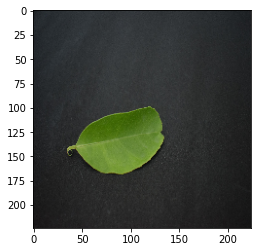

(32, 224, 224, 3)


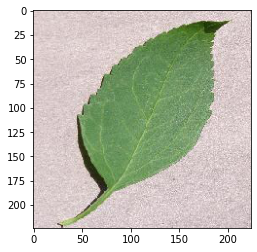

(32, 224, 224, 3)


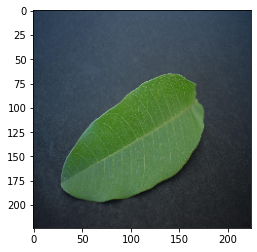

(32, 224, 224, 3)


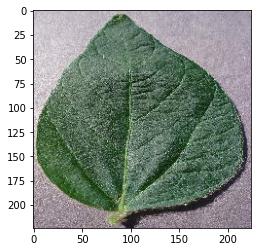

(32, 224, 224, 3)


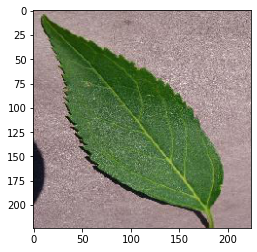

In [ ]:
for _ in range(5):
    img, label = vgg16_model.validation_generator.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

## Train Model

In [ ]:
reduce_lr_config = {
    'monitor': 'val_loss',
    'factor': 0.05, 
    'patience':5, 
    'min_lr': 0.000002
}
vgg16_model.train(model_name='vgg16', reduce_lr_config=reduce_lr_config)

Epoch 1/20
71/71 [==============================] - ETA: 0s - loss: 1.2296 - acc: 0.5476 
Epoch 1: val_acc improved from -inf to 0.88976, saving model to vgg16-saved-model-01-acc-0.89.hdf5
71/71 [==============================] - 1550s 22s/step - loss: 1.2296 - acc: 0.5476 - val_loss: 0.3414 - val_acc: 0.8898 - lr: 1.0000e-04
Epoch 2/20
71/71 [==============================] - ETA: 0s - loss: 0.5292 - acc: 0.8071
Epoch 2: val_acc improved from 0.88976 to 0.94961, saving model to vgg16-saved-model-02-acc-0.95.hdf5
71/71 [==============================] - 445s 6s/step - loss: 0.5292 - acc: 0.8071 - val_loss: 0.1750 - val_acc: 0.9496 - lr: 1.0000e-04
Epoch 3/20
71/71 [==============================] - ETA: 0s - loss: 0.3809 - acc: 0.8698
Epoch 3: val_acc improved from 0.94961 to 0.95118, saving model to vgg16-saved-model-03-acc-0.95.hdf5
71/71 [==============================] - 443s 6s/step - loss: 0.3809 - acc: 0.8698 - val_loss: 0.1601 - val_acc: 0.9512 - lr: 1.0000e-04
Epoch 4/20
71/71

## History

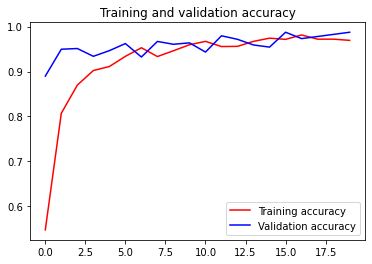

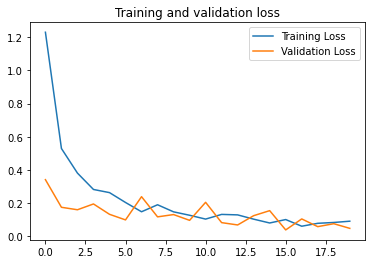

In [ ]:
vgg16_model.plot_history()

## Evaluate Model

11/11 [==============================] - 48s 5s/step - loss: 0.0689 - acc: 0.9822
Loss of the model is -  0.06885932385921478
Accuracy of the model is -  98.21958541870117 %
              precision    recall  f1-score   support

      Anggur       1.00      1.00      1.00        37
        Apel       1.00      0.97      0.99        37
        Ceri       1.00      1.00      1.00        37
      Delima       0.97      1.00      0.99        37
    Jamblang       1.00      1.00      1.00        34
  Jambu Biji       0.98      0.96      0.97        50
     Kedelai       0.97      1.00      0.99        37
       Lemon       0.96      0.96      0.96        23
      Mangga       0.96      0.96      0.96        45

    accuracy                           0.98       337
   macro avg       0.98      0.98      0.98       337
weighted avg       0.98      0.98      0.98       337

Confusion Matrix


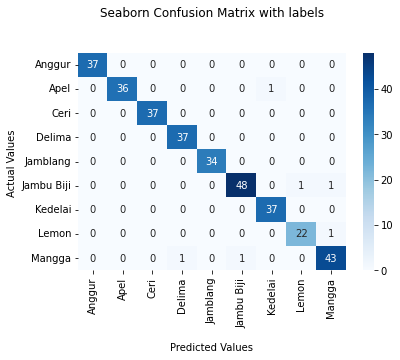

In [ ]:
vgg16_model.evaluate_model()

In [ ]:
vgg16_model.model_name = 'vgg16'
vgg16_model.find_best_model('.')

AttributeError: ignored

## Evaluate Best Model

In [ ]:
vgg16_model.evaluate_best_model()

In [ ]:
target_dir = '/content/drive/Shareddrives/Bangkit Capstone/Best Model'
vgg16_model.save_best_model(target_dir=target_dir)

# InceptionV3

## Build Model

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as iv3_preprocess_input

config = {
    "batch_size": 32,
    "epochs": 20,
    "classes": 9,
    "input_shape": (224, 224, 3)

}

compile_config = {
    "loss": "sparse_categorical_crossentropy",
    "optimizer": Adam(learning_rate=0.0001),
    "metrics": ["accuracy"],
}

inceptionv3  = InceptionV3(weights="imagenet", include_top=False, input_shape=config['input_shape'],)
for layer in inceptionv3.layers[:249]:
   layer.trainable = True
for layer in inceptionv3.layers[249:]:
   layer.trainable = True

custom_layer = [
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu')
]

iv3_model = Model(model=inceptionv3, config=config)
iv3_model.train_val_generators(train_dir, validation_dir, test_dir, preprocess_input=iv3_preprocess_input)
iv3_model.build_model(compile_config, custom_layer=custom_layer)

Found 2250 images belonging to 9 classes.
Found 635 images belonging to 9 classes.
Found 337 images belonging to 9 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_2 (Flatten)         (None, 51200)             0         
                                                                 
 dropout_2 (Dropout)         (None, 51200)             0         
                                                                 
 dense_8 (Dense)             (None, 512)               26214912  
                                                                 
 dense_9 (Dense)             (None, 1024)              525312    
                                                                 
 dense_10 (Dense)            (None, 1024)              1049600

## Train Model

In [ ]:
reduce_lr_config = {
    'monitor': 'val_loss',
    'factor': 0.05, 
    'patience':5, 
    'min_lr': 0.000002
}
iv3_model.train('inceptionv3', reduce_lr_config=reduce_lr_config)

Epoch 1/20
71/71 [==============================] - ETA: 0s - loss: 0.9309 - acc: 0.6689
Epoch 1: val_acc improved from -inf to 0.84094, saving model to inceptionv3-saved-model-01-acc-0.84.hdf5
71/71 [==============================] - 469s 7s/step - loss: 0.9309 - acc: 0.6689 - val_loss: 0.6685 - val_acc: 0.8409 - lr: 1.0000e-04
Epoch 2/20
71/71 [==============================] - ETA: 0s - loss: 0.2385 - acc: 0.9298
Epoch 2: val_acc improved from 0.84094 to 0.95276, saving model to inceptionv3-saved-model-02-acc-0.95.hdf5
71/71 [==============================] - 453s 6s/step - loss: 0.2385 - acc: 0.9298 - val_loss: 0.1383 - val_acc: 0.9528 - lr: 1.0000e-04
Epoch 3/20
71/71 [==============================] - ETA: 0s - loss: 0.1635 - acc: 0.9480
Epoch 3: val_acc improved from 0.95276 to 0.97638, saving model to inceptionv3-saved-model-03-acc-0.98.hdf5
71/71 [==============================] - 451s 6s/step - loss: 0.1635 - acc: 0.9480 - val_loss: 0.0963 - val_acc: 0.9764 - lr: 1.0000e-04
E

## History

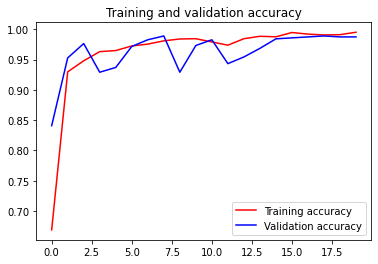

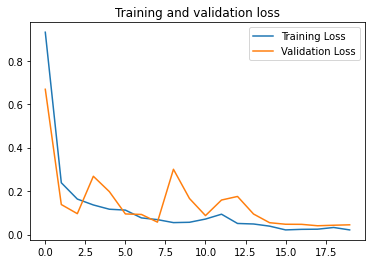

In [ ]:
iv3_model.plot_history()

## Evaluate Model

11/11 [==============================] - 149s 15s/step - loss: 0.0738 - acc: 0.9852
Loss of the model is -  0.07380156219005585
Accuracy of the model is -  98.51632118225098 %
              precision    recall  f1-score   support

      Anggur       1.00      1.00      1.00        37
        Apel       1.00      1.00      1.00        37
        Ceri       1.00      1.00      1.00        37
      Delima       1.00      0.97      0.99        37
    Jamblang       0.97      0.97      0.97        34
  Jambu Biji       0.98      0.96      0.97        50
     Kedelai       1.00      1.00      1.00        37
       Lemon       0.96      1.00      0.98        23
      Mangga       0.96      0.98      0.97        45

    accuracy                           0.99       337
   macro avg       0.99      0.99      0.99       337
weighted avg       0.99      0.99      0.99       337

Confusion Matrix


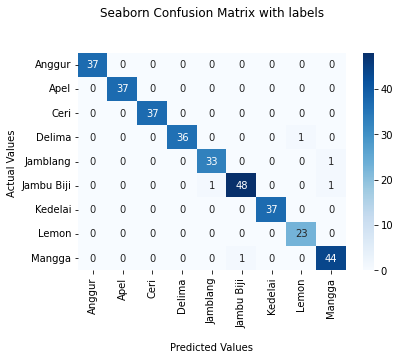

In [ ]:
iv3_model.evaluate_model()

## Evaluate Best Model

./inceptionv3-saved-model-08-acc-0.99.hdf5
11/11 [==============================] - 47s 5s/step - loss: 0.0801 - acc: 0.9881
Loss of the model is -  0.08013256639242172
Accuracy of the model is -  98.81305694580078 %
              precision    recall  f1-score   support

      Anggur       1.00      1.00      1.00        37
        Apel       1.00      1.00      1.00        37
        Ceri       1.00      1.00      1.00        37
      Delima       1.00      1.00      1.00        37
    Jamblang       0.97      1.00      0.99        34
  Jambu Biji       0.96      0.96      0.96        50
     Kedelai       1.00      1.00      1.00        37
       Lemon       1.00      1.00      1.00        23
      Mangga       0.98      0.96      0.97        45

    accuracy                           0.99       337
   macro avg       0.99      0.99      0.99       337
weighted avg       0.99      0.99      0.99       337

Confusion Matrix


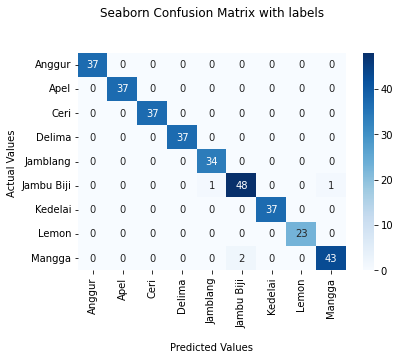

In [ ]:
iv3_model.model_name = 'inceptionv3'
iv3_model.find_best_model('.')
iv3_model.evaluate_best_model()

In [ ]:
target_dir = '/content/drive/Shareddrives/Bangkit Capstone/Best Model'
iv3_model.save_best_model(target_dir=target_dir)

Copy ./inceptionv3-saved-model-08-acc-0.99.hdf5 to /content/drive/Shareddrives/Bangkit Capstone/Best Model


# Predict Image

In [ ]:
iv3_model.model.load_weights("/content/inceptionv3-saved-model-08-acc-0.99.hdf5")

In [ ]:
def load_image(img_path, show=False):

    img = load_img(img_path, target_size=(224, 224))
    img_tensor = img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [ ]:
!wget https://cdn.discordapp.com/attachments/971451202267119678/977474392105844796/IMG20220521143322.jpg -O jbiji.png

--2022-06-10 17:51:09--  https://cdn.discordapp.com/attachments/971451202267119678/977474392105844796/IMG20220521143322.jpg
Resolving cdn.discordapp.com (cdn.discordapp.com)... 162.159.129.233, 162.159.130.233, 162.159.133.233, ...
Connecting to cdn.discordapp.com (cdn.discordapp.com)|162.159.129.233|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2382998 (2.3M) [image/jpeg]
Saving to: ‘jbiji.png’

jbiji.png           100%[===================>]   2.27M  --.-KB/s    in 0.06s   

2022-06-10 17:51:09 (37.3 MB/s) - ‘jbiji.png’ saved [2382998/2382998]



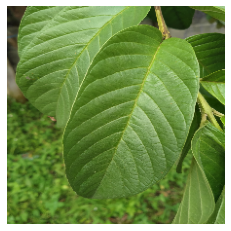

Jambu Biji
Anggur: 0.13577848440036178
Apel: 8.988088369369507
Ceri: 0.6611558608710766
Delima: 0.2635074080899358
Jamblang: 1.5461335889995098
Jambu Biji: 72.14477062225342
Kedelai: 13.36739957332611
Lemon: 2.6461444795131683
Mangga: 0.24702728260308504


In [ ]:
model = iv3_model.model
label_map = (iv3_model.train_generator.class_indices)
label_map = {v: k for k, v in label_map.items()}
image_path ='jbiji.png'
image = load_image(image_path, show=True)
predict = model.predict(image)
print(label_map[np.argmax(model.predict(image))])
predicted_list = [ele * 100 for ele in predict.flatten()]

for idx, ele in enumerate(predicted_list):
  print(f"{label_map[idx]}: {ele}")

In [ ]:
def predict_false_images(images):
  model = iv3_model.model
  label_map = (iv3_model.train_generator.class_indices)
  label_map = {v: k for k, v in label_map.items()}
  # image_path ='/content/drive/Shareddrives/Bangkit Capstone/Plant_leave_diseases_dataset_without_augmentation/Background_without_leaves/image (138).jpg'
  count = 0
  image_files = os.listdir(images)
  for img in image_files:
    image = os.path.join(images, img)
    image = load_image(image, show=False)
    predict = model.predict(image)
    # label_predict = label_map[np.argmax(predict)]
    predicted_list = [ele * 100 for ele in predict.flatten()]
    max_pred_acc = max(predicted_list)
  
    if max_pred_acc >=80:
      count += 1
  
  print(f"False predicted image  = {count} from {len(image_files)}")
  

predict_false_images('/content/drive/Shareddrives/Bangkit Capstone/Plant_leave_diseases_dataset_without_augmentation/Background_without_leaves/') 

False predicted image  = 158 from 1143


# Save Model

In [ ]:
!pip install tensorflowjs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 6.6 MB/s 
     |████████████████████████████████| 40 kB 5.9 MB/s 
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
vgg16_model.model.save("asd", save_format='tf')

INFO:tensorflow:Assets written to: asd/assets


In [ ]:
!tensorflowjs_converter --input_format tf_saved_model --output_format tfjs_graph_model asd vgg16_saved_model

2022-06-07 08:39:14.320473: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-07 08:39:15.869340: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
2022-06-07 08:39:16.015684: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
2022-06-07 08:39:16.108850: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
2022-06-07 08:39:16.598163: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
2022-06-07 08:39:19.941624: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 51380224 exceeds 10% of free system memory.
Writing weight file vgg16_saved_model/model.json...


In [ ]:
!zip -r vgg16_best_model_last.zip vgg16_saved_model

  adding: vgg16_saved_model/ (stored 0%)
  adding: vgg16_saved_model/group1-shard16of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard2of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard10of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard3of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard7of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard25of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard8of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard27of28.bin (deflated 8%)
  adding: vgg16_saved_model/group1-shard12of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard28of28.bin (deflated 8%)
  adding: vgg16_saved_model/group1-shard17of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard20of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard23of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard5of28.bin (deflated 7%)
  adding: vgg16_saved_model/group1-shard14of28.bin (de

In [ ]:
!cp vgg16_best_model_last.zip /content/drive/Shareddrives/Bangkit\ Capstone/Saved\ model

# Miscellaneous

In [ ]:
vgg16_model.train_generator.class_indices

{'Anggur': 0,
 'Apel': 1,
 'Ceri': 2,
 'Delima': 3,
 'Jamblang': 4,
 'Jambu Biji': 5,
 'Kedelai': 6,
 'Lemon': 7,
 'Mangga': 8,
 'Pepaya': 9}